# TMLE Example Notebook

This notebook demonstrates the issue of using uplift curves without knowing true treatment effect and how to solve it by using TMLE as a proxy of the true treatment effect.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import sys
import warnings
warnings.simplefilter("ignore", UserWarning)

from lightgbm import LGBMRegressor

In [12]:
import causalml

from causalml.dataset import synthetic_data
from causalml.inference.meta import BaseXRegressor, TMLELearner
from causalml.metrics.visualize import plot
from causalml.propensity import calibrate

print(causalml.__version__)

0.7.0


In [14]:
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)
plt.style.use('fivethirtyeight')

## Generating Synthetic Data

In [15]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=1000000, p=10, sigma=5.)

In [16]:
X_train, X_test, y_train, y_test, e_train, e_test, treatment_train, treatment_test, tau_train, tau_test, b_train, b_test = train_test_split(X, y, e, treatment, tau, b, test_size=0.5, random_state=42)

## Calculating Individual Treatment Effect (ITE/CATE)

In [17]:
# X Learner
learner_x = BaseXRegressor(learner=LGBMRegressor())
learner_x.fit(X=X_train, treatment=treatment_train, y=y_train)
cate_x_test = learner_x.predict(X=X_test, p=e_test, treatment=treatment_test).flatten()

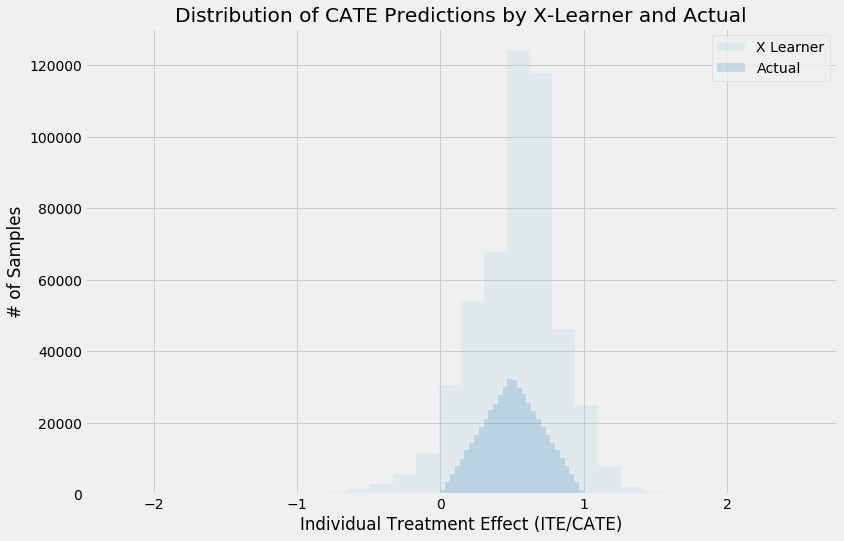

In [18]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_x_test, alpha=alpha, bins=bins, label='X Learner')
plt.hist(tau_test, alpha=alpha, bins=bins, label='Actual')

plt.title('Distribution of CATE Predictions by X-Learner and Actual')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

## Validating CATE without TMLE

In [382]:
df = pd.DataFrame({'y': y_test, 'w': treatment_test, 'tau': tau_test, 'X-Learner': cate_x_test, 'Actual': tau_test})

In [389]:
cumlift = get_cumlift(df, outcome_col='y', treatment_col='w', treatment_effect_col='tau',
            random_seed=42)

In [390]:
cumlift.head(n=20)

,X-Learner,Actual,Random
0,0.000000,0.000000,0.000000
1,0.607158,0.999363,0.363275
2,0.795826,0.999040,0.413099
3,0.589604,0.998762,0.472573
4,0.499075,0.998577,0.472678
5,0.497250,0.998454,0.493539
6,0.520808,0.998294,0.511504
7,0.582490,0.998156,0.503960
8,0.521461,0.998036,0.499284
9,0.544477,0.997941,0.482906


In [391]:
cumqini = get_qini(df, outcome_col='y', treatment_col='w', treatment_effect_col='tau',
             normalize=False, random_seed=42)

In [409]:
cumqini.tail(n=20)

,X-Learner,Actual,Random
499981,129729.799022,129734.944344,129725.607646
499982,129730.076683,129734.687027,129725.818525
499983,129730.421203,129734.429683,129726.041799
499984,129730.717577,129734.172292,129726.300537
499985,129731.399921,129733.914806,129726.536959
499986,129731.403078,129733.657209,129726.856424
499987,129731.202021,129733.399575,129727.065932
499988,129731.093253,129733.141929,129727.270485
499989,129730.935962,129732.884205,129727.609292
499990,129730.767557,129732.626449,129727.753180


In [384]:
get_qini(df, outcome_col='y', treatment_col='w',
             normalize=False, random_seed=42)

,X-Learner,Actual,Random
0,0.000000,0.000000,0.000000
1,0.607158,0.000000,0.090913
2,0.795826,0.000000,0.211389
3,0.589604,0.000000,0.468500
4,0.499075,0.000000,0.577069
...,...,...,...
499996,129730.500529,129731.078139,129728.882392
499997,129730.313065,129730.819498,129729.092817
499998,129730.215975,129730.560767,129729.403892
499999,129730.083777,129730.301951,129729.776049


### Uplift Curve With Ground Truth

If true treatment effect is known as in simulations, the uplift curve of a model uses the cumulative sum of the treatment effect sorted by model's CATE estimate.

In the figure below, the uplift curve of X-learner shows positive lift close to the optimal lift by the ground truth.

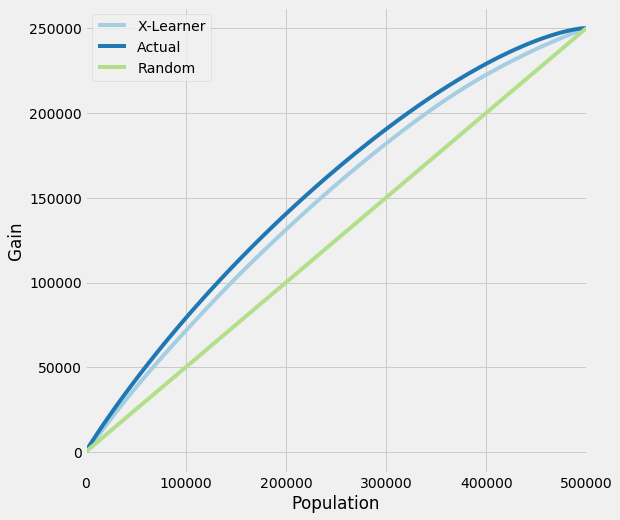

In [20]:
plot(df, outcome_col='y', treatment_col='w', treatment_effect_col='tau')

### Uplift Curve Without Ground Truth

If true treatment effect is unknown as in practice, the uplift curve of a model uses the cumulative mean difference of outcome in the treatment and control group sorted by model's CATE estimate.

In the figure below, the uplift curves of X-learner as well as the ground truth show no lift incorrectly.

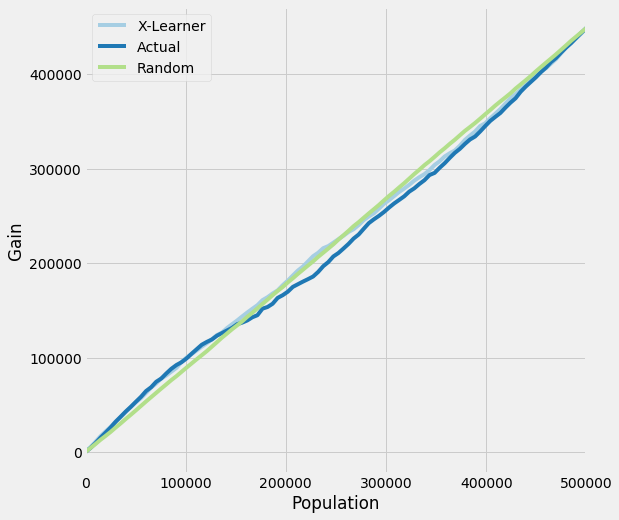

In [256]:
plot(df.drop('tau', axis=1), outcome_col='y', treatment_col='w')

### Qini Curve With Ground Truth

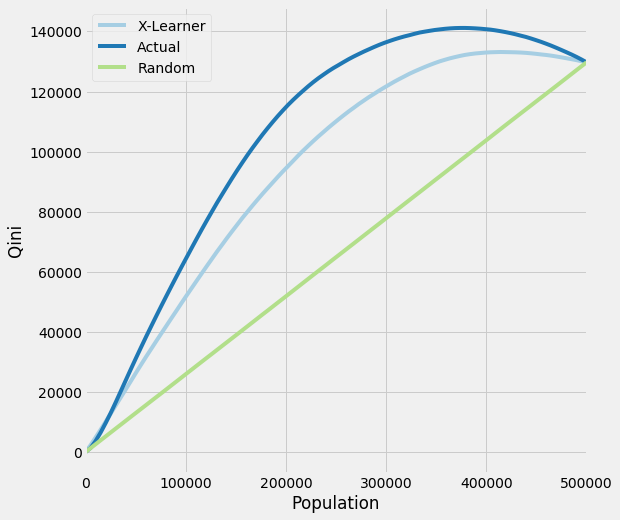

In [259]:
plot(df, kind='qini', outcome_col='y', treatment_col='w', treatment_effect_col='tau')

### Qini Curve Without Ground Truth

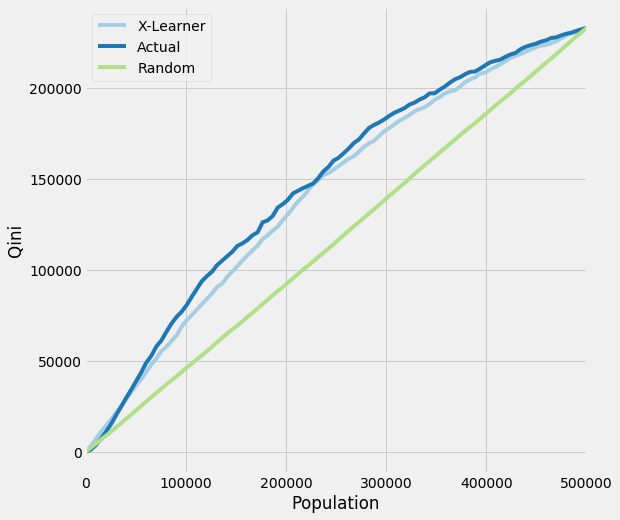

In [257]:
plot(df.drop('tau', axis=1), kind='qini', outcome_col='y', treatment_col='w')

## TMLE 

In [22]:
n_fold = 5
n_segment = 5

### TMLE Model Training

In [23]:
kf = KFold(n_splits=n_fold)

In [311]:
tmle = TMLELearner(learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300), 
                   cv=kf, calibrate_propensity=True)

ate_all, ate_all_lb, ate_all_ub = tmle.estimate_ate(X=X_test, p=e_test, treatment=treatment_test, y=y_test)

ate_all, ate_all_lb, ate_all_ub

(array([0.50253018]), array([0.4642327]), array([0.54082766]))

In [25]:
tmle = TMLELearner(learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300), 
                   cv=kf, calibrate_propensity=True)

ate_actual, ate_actual_lb, ate_actual_ub = tmle.estimate_ate(X=X_test, p=e_test, treatment=treatment_test, y=y_test, segment=pd.qcut(tau_test, n_segment, labels=False))

ate_actual, ate_actual_lb, ate_actual_ub

(array([[0.26543387, 0.36855965, 0.48845904, 0.61939758, 0.77377596]]),
 array([[0.16995549, 0.29359462, 0.41833461, 0.52875802, 0.67792831]]),
 array([[0.36091225, 0.44352467, 0.55858348, 0.71003714, 0.8696236 ]]))

In [26]:
tmle = TMLELearner(learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300), 
                   cv=kf, calibrate_propensity=True)

ate_xlearner, ate_xlearner_lb, ate_xlearner_ub = tmle.estimate_ate(X=X_test, p=e_test, treatment=treatment_test, y=y_test, segment=pd.qcut(cate_x_test, n_segment, labels=False))

ate_xlearner, ate_xlearner_lb, ate_xlearner_ub

(array([[0.32882726, 0.38089483, 0.5447974 , 0.53294664, 0.72642021]]),
 array([[0.23809607, 0.30178478, 0.46650983, 0.44323542, 0.63495749]]),
 array([[0.41955846, 0.46000487, 0.62308496, 0.62265787, 0.81788294]]))

In [206]:
tmle_df

,X-Learner,Actual,Random
0.0,0.000000,0.000000,0.000000
0.2,0.145284,0.154755,0.100506
0.4,0.251873,0.278635,0.201012
0.6,0.360833,0.376327,0.301518
0.8,0.437012,0.450038,0.402024
1.0,0.502530,0.502530,0.502530


### Uplift Curve with TMLE as Ground Truth

By using TMLE as a proxy of the ground truth, the uplift curves of X-learner and the ground truth become close to the original using the ground truth.

Text(0,0.5,'Lift in GB')

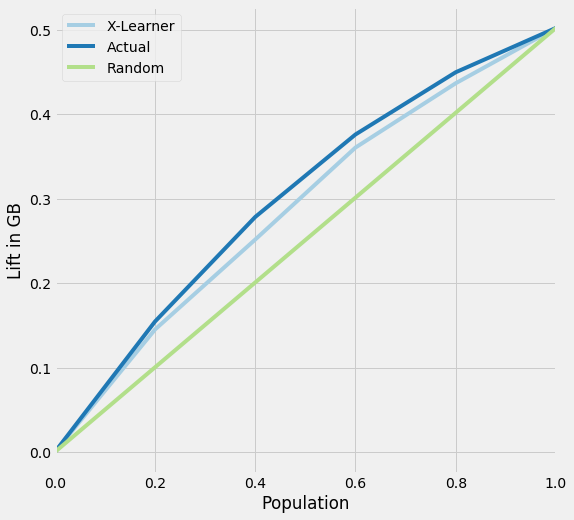

In [406]:
lift_actual = [0.] * (n_segment + 1)
lift_actual[n_segment] = ate_all[0]

lift_xlearner = [0.] * (n_segment + 1)
lift_xlearner[n_segment] = ate_all[0]

for i in range(1, n_segment):
    lift_actual[i] = ate_actual[0][n_segment - i] * .2 + lift_actual[i - 1]
    lift_xlearner[i] = ate_xlearner[0][n_segment - i] * .2 + lift_xlearner[i - 1]     

pd.DataFrame({'Population': np.linspace(0, 1, n_segment + 1),
              'Actual': lift_actual,
              'X-Learner': lift_xlearner,
              'Random': np.linspace(0, 1, n_segment + 1)*lift_actual[-1]}).plot(x='Population', 
                                                                                y=['X-Learner', 'Actual', 'Random'], 
                                                                                figsize=(8, 8))
plt.ylabel('Lift in GB')

### Uplift Curve with TMLE as Ground Truth Direct API Call

In [28]:
# sys.path.append('../')
# from causalml.metrics.visualize import *

In [446]:
df = pd.DataFrame({'y': y_test, 'w': treatment_test, 'p': e_test, 'X-Learner': cate_x_test, 'Actual': tau_test})

In [447]:
inference_cols = []
for i in range(X_test.shape[1]):
    col = 'col_' + str(i)
    df[col] = X_test[:,i]
    inference_cols.append(col)

In [448]:
df.head()

,y,w,p,X-Learner,Actual,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9
0,3.778378,0,0.100000,-0.782236,0.135405,0.237337,0.033474,0.591565,0.052522,0.116221,0.719529,0.987473,0.734260,0.682046,0.729316
1,-2.199225,1,0.752610,1.302406,0.856267,0.922584,0.789949,0.966232,0.936588,0.286977,0.468190,0.720490,0.765360,0.105228,0.192054
2,6.788447,0,0.697294,0.780866,0.566408,0.292172,0.840644,0.875405,0.337779,0.017612,0.955533,0.365899,0.856734,0.316591,0.233872
3,1.162070,0,0.100000,-0.120661,0.274801,0.026420,0.523181,0.041829,0.841536,0.302662,0.819091,0.196584,0.691260,0.705401,0.410077
4,8.614277,1,0.900000,0.753982,0.757903,0.956986,0.558821,0.206172,0.410747,0.623732,0.223546,0.526751,0.367133,0.179813,0.900150


In [205]:
tmle_df = get_tmlelift(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
                       inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                       n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

In [184]:
tmle_df

,X-Learner,Actual,Random
0.0,0.000000,0.000000,0.000000
0.2,0.145284,0.154755,0.100506
0.4,0.251873,0.278635,0.201012
0.6,0.360833,0.376327,0.301518
0.8,0.437012,0.450038,0.402024
1.0,0.502530,0.502530,0.502530


#### Uplift Curve

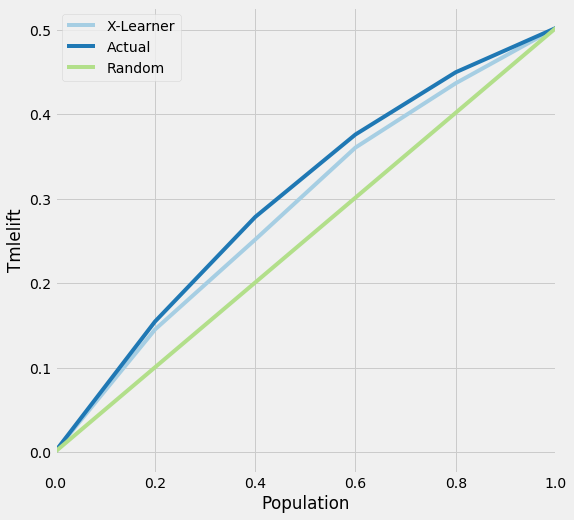

In [203]:
plot_tmlelift(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
     inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

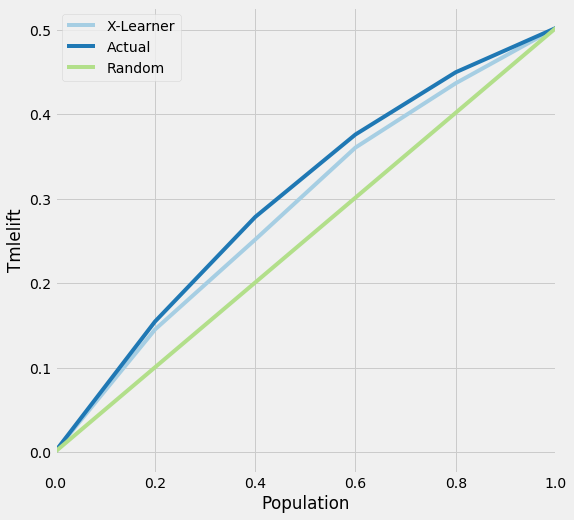

In [196]:
plot(df, kind='tmlelift', learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
     inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

#### AUUC Score

In [216]:
auuc_score_tmle(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
                inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

X-Learner    0.199741
Actual       0.205127
Random       0.184261
dtype: float64

### Uplift Curve with TMLE as Ground Truth Direct API Call including CI

In [185]:
tmle_df = get_tmlelift(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
                   inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                   n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

In [186]:
tmle_df

,X-Learner,Actual,X-Learner LB,Actual LB,X-Learner UB,Actual UB,Random
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.2,0.145284,0.154755,0.126991,0.135586,0.163577,0.173925,0.100506
0.4,0.251873,0.278635,0.215639,0.241337,0.288108,0.315932,0.201012
0.6,0.360833,0.376327,0.308941,0.325004,0.412725,0.427649,0.301518
0.8,0.437012,0.450038,0.369298,0.383723,0.504726,0.516354,0.402024
1.0,0.502530,0.502530,0.464233,0.464233,0.540828,0.540828,0.502530


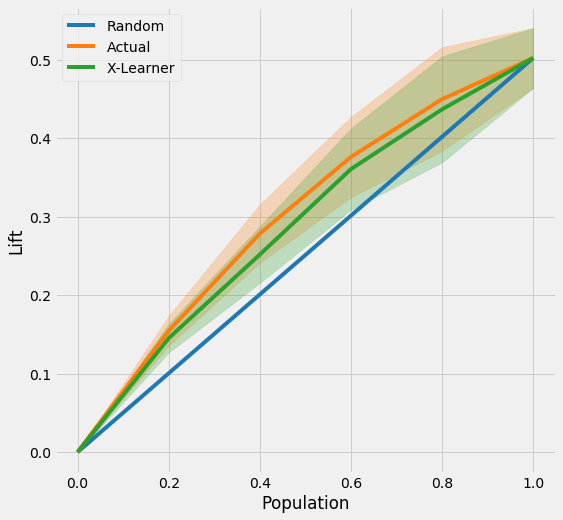

In [175]:
plot_tmle(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
     inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

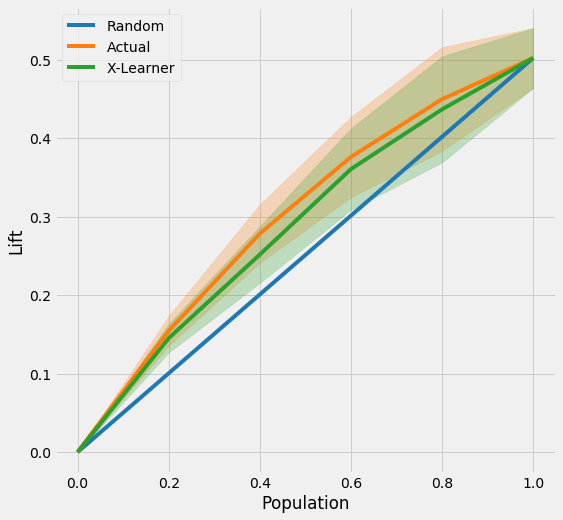

In [182]:
plot(df, kind='tmlelift', ci=True, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
     inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True)